<b>NB!</b> The installment of Numpy / Pandas below were necessary to run the Numpy and Pandas dependent libraries.

In [37]:
%pip install pandas
%pip install numpy
%pip install statsmodels.stats.outliers_influence

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement statsmodels.stats.outliers_influence (from versions: none)
ERROR: No matching distribution found for statsmodels.stats.outliers_influence
Note: you may need to restart the kernel to use updated packages.


In [38]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import warnings
import time
warnings.filterwarnings('ignore')

### Load data

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Configure display settings for better output readability
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

train_file_path = '../data/cleaned/cleaned_ais_train_dataset.csv'
vessels_file_path = '../data/cleaned/cleaned_vessels.csv'

# Load the data
def load_data(train_file_path, vessels_file_path):
    train = pd.read_csv(train_file_path, sep=',')
    vessels = pd.read_csv(vessels_file_path, sep=',')
    train['time'] = pd.to_datetime(train['time'])
    train = train.sort_values(by=['vesselId', 'time'])
    return train, vessels

train, vessels = load_data(train_file_path, vessels_file_path)
    
    # Merge vessels data with train data
train = train.merge(vessels, on='vesselId', how='left')

## 1. Understanding the structure of the data

In [41]:
print("Data Info:")
print(train.info())
print("\nDescriptive Statistics (Numerical Columns):")
print(train.describe())
print("\nDescriptive Statistics (Categorical Columns):")
print(train.describe(include='object'))

Data Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1515960 entries, 0 to 1515959
Data columns (total 30 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   time            1515960 non-null  datetime64[ns]
 1   cog             1515960 non-null  float64       
 2   sog             1515960 non-null  float64       
 3   rot             1515960 non-null  int64         
 4   heading         1515960 non-null  int64         
 5   navstat         1515960 non-null  int64         
 6   etaRaw          1512251 non-null  object        
 7   latitude        1515960 non-null  float64       
 8   longitude       1515960 non-null  float64       
 9   vesselId        1515960 non-null  object        
 10  portId          1515960 non-null  object        
 11  shippingLineId  1515960 non-null  object        
 12  CEU             1515960 non-null  int64         
 13  DWT             1501035 non-null  float64       
 14  GT     

See that the cathegorical variables are vesselType and HomePort, these need to be checked for unique values

#### Checking uniqueness in cathegorical variables 

In [42]:
categorical_cols = ['vesselType', 'homePort']
for col in categorical_cols:
    print(f"\nUnique values in '{col}':")
    print(train[col].unique())


Unique values in 'vesselType':
['83.0' 'Unknown' '21.0' '14.0']

Unique values in 'homePort':
['OSLO' 'MONROVIA' "SAINT JOHN'S" 'Unknown' 'Panama' 'NASSAU' 'Kobe'
 'Singapore' 'Port Kelang' 'Majuro' 'NORFOLK VA' 'STOCKHOLM' 'VALLETTA'
 'TONSBERG' 'WILMINGTON DE' 'SOUTHAMPTON' 'Tokyo'
 'Kaminoseki-Cho, Yamaguchi Pref.' 'ROSTOCK' 'PALERMO' 'Kuching'
 'Monrovia' 'Nassau' 'Tahara' 'George Town' 'London' 'JEJU CHEJU'
 'HONG KONG' 'MAJURO' 'Fukuoka' 'ALVERCA' 'LIVERPOOL' 'NEW YORK NY'
 'DELFZIJL' 'LONDON' 'PIRAEUS' 'MOBILE AL' 'Omuta' 'SINGAPORE' 'HELSINKI'
 'MALMO' 'MARIEHAMN' 'JAKOBSTAD' 'LIMASSOL' 'BARI' 'SAN FRANCISCO CA'
 'PANAMA' 'Limassol' 'Madeira' 'SHIZUOKA' 'Tokai']


### Correlation analysis


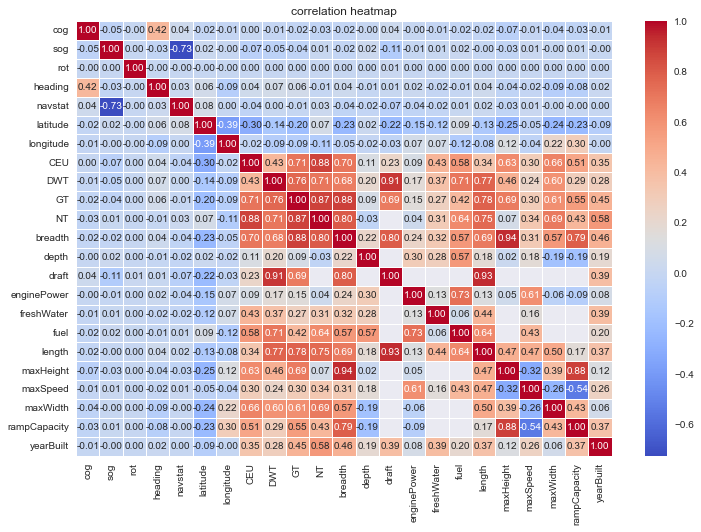

In [43]:
plt.figure(figsize=(12, 8))
corr = train.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("correlation heatmap")
plt.show()

- From the correlation heat map we can see that some vessel features are significantly correlated to others, like "yearBuilt" and "vessel_age". Need to explore if these it is possible to create interacting terms or scale them. 

- Given that some features show high correlations (e.g., CEU, DWT, and other tonnage-related variables), we need to explore clustering analysis to see if vessels can be grouped into different categories based on these.

- Need to look into maxSpeed, enginePower etc as they have high variability which might indicate outliers


#### Understanding the distribution of cathegorical features

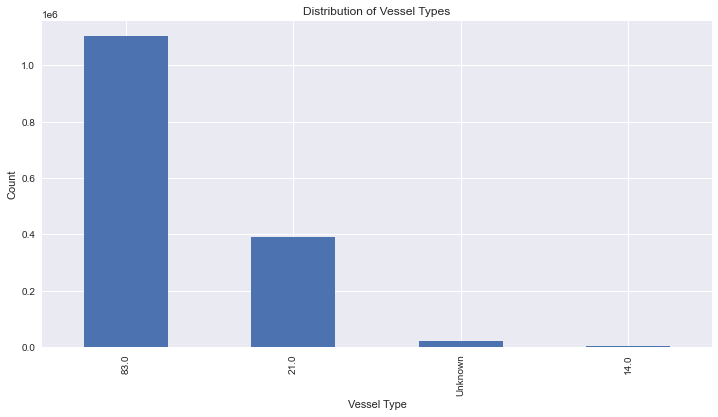

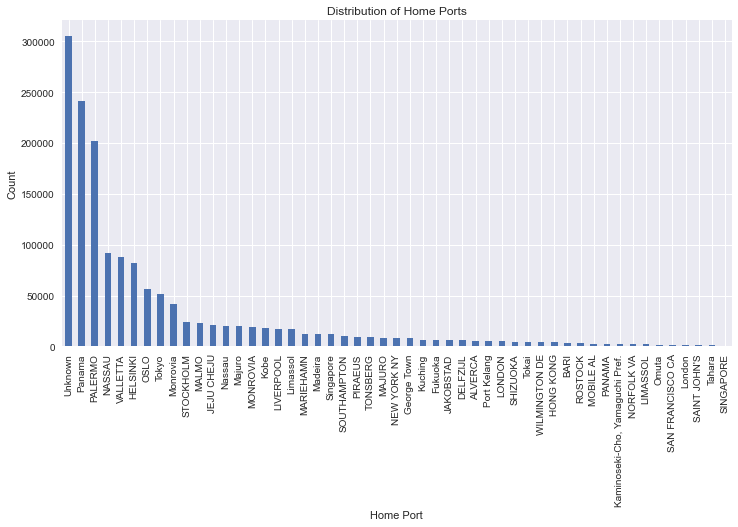

In [44]:
plt.figure(figsize=(12, 6))
train['vesselType'].value_counts().plot(kind='bar')
plt.title('Distribution of Vessel Types')
plt.xlabel('Vessel Type')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(12, 6))
train['homePort'].value_counts().plot(kind='bar')
plt.title('Distribution of Home Ports')
plt.xlabel('Home Port')
plt.ylabel('Count')
plt.show()

### Checking for multicollinearity using Variance Inflation Factor (VIF)

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select numeric columns
numeric_columns = train.select_dtypes(include=[np.number]).columns.tolist()
X = train[numeric_columns]

# Fill missing values with column means
X_filled = X.fillna(X.mean())

# Remove columns with zero variance
X_filled = X_filled.loc[:, X_filled.var() != 0]

# Check for highly correlated features (threshold set to 0.95)
correlation_matrix = X_filled.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]

# Drop these columns from X_filled
X_filtered = X_filled.drop(columns=to_drop)

# Calculate VIF for each feature in the filtered dataset
vif_data = pd.DataFrame()
vif_data['Feature'] = X_filtered.columns
vif_data['VIF'] = [variance_inflation_factor(X_filtered.values, i) for i in range(X_filtered.shape[1])]

# Display the VIF data
vif_data_sorted = vif_data.sort_values(by='VIF', ascending=False)
print(vif_data_sorted)




         Feature          VIF
22     yearBuilt  6634.634363
19      maxSpeed  4654.933138
18     maxHeight  1664.246853
13         draft   934.874886
16          fuel   450.027431
12         depth   312.660972
11       breadth   273.976067
10            NT   201.211606
17        length   192.982960
21  rampCapacity   173.354543
20      maxWidth   156.402610
9             GT    65.726700
15    freshWater    56.680648
8            DWT    19.319815
7            CEU    11.815717
5       latitude     4.973645
3        heading     4.687146
0            cog     4.608670
4        navstat     3.854087
1            sog     3.816671
14   enginePower     1.930495
6      longitude     1.280381
2            rot     1.000059


#### Vizualising highly correlated features

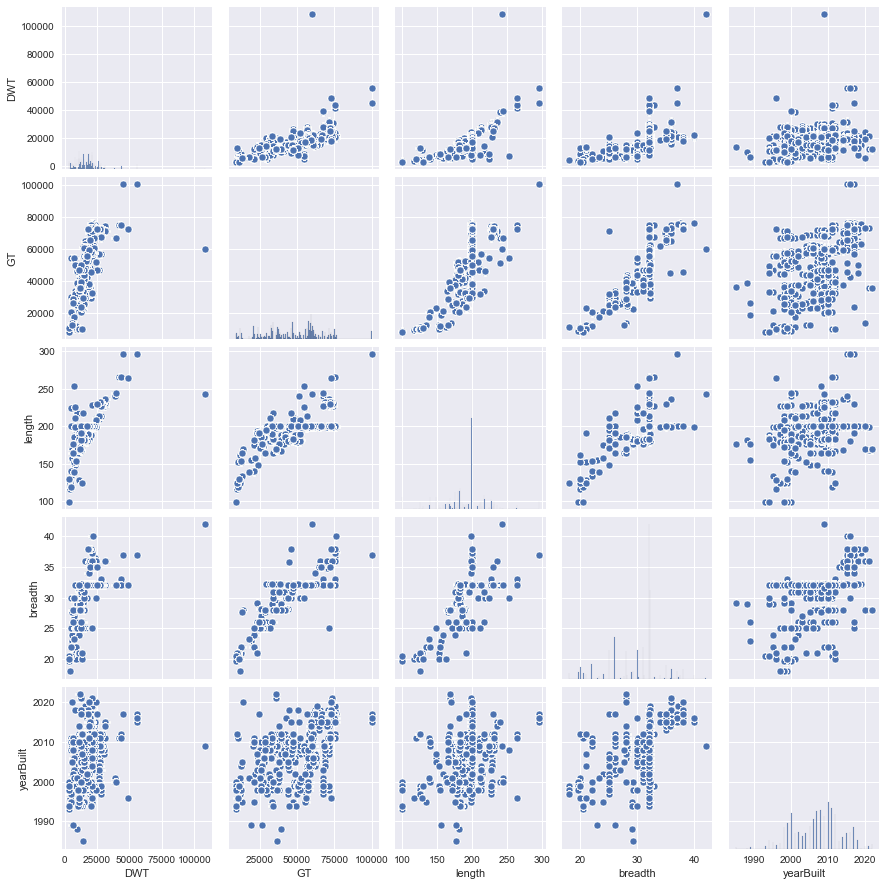

In [57]:
# Select highly correlated features
high_corr_features = ['DWT', 'GT', 'length', 'breadth', 'yearBuilt']

# Visualize pairwise relationships
sns.pairplot(train[high_corr_features])
plt.show()


### Clustering and K-means

In [58]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [59]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Select features for clustering
clustering_features = ['CEU', 'DWT', 'GT', 'length', 'breadth', 'draft']

# Drop missing values and fill as necessary
X = train[clustering_features].dropna()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Apply k-means clustering with the optimal number of clusters (adjust based on the elbow plot)
optimal_clusters = 3  # Adjust based on the elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
X['Cluster'] = kmeans.fit_predict(X_scaled)

# Add the cluster labels back to the original dataset
train['Cluster'] = X['Cluster']

# Visualize the clusters
sns.pairplot(train, vars=clustering_features, hue='Cluster', palette='viridis')
plt.suptitle('K-means Clustering Results', y=1.02)
plt.show()

# Calculate the silhouette score to evaluate clustering quality
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg:.2f}')


AttributeError: 'NoneType' object has no attribute 'split'

As DWT, GT and length is tightly correlated, it might be beneficial to remove DWT and length to reduce multicollinearity
We see also indications of 

## 2. Exploratory Data Analysis (EDA)


Vessel Age Summary Statistics:
count    1.515960e+06
mean     1.694870e+01
std      6.477105e+00
min      2.000000e+00
25%      1.300000e+01
50%      1.600000e+01
75%      2.200000e+01
max      3.900000e+01
Name: vessel_age, dtype: float64


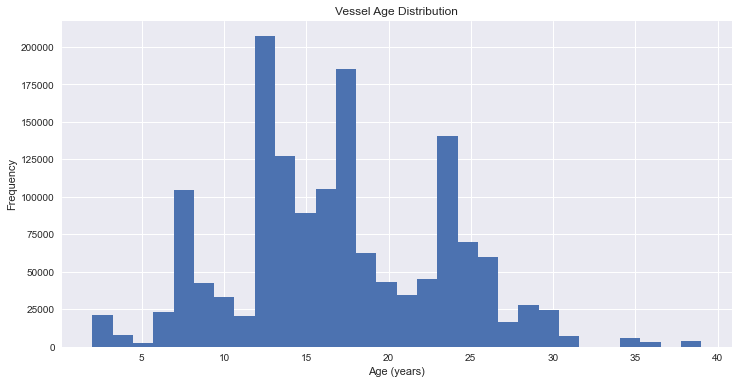

In [25]:
train['vessel_age'] = train['time'].dt.year - train['yearBuilt']
print("\nVessel Age Summary Statistics:")
print(train['vessel_age'].describe())

plt.figure(figsize=(12, 6))
train['vessel_age'].plot(kind='hist', bins=30)
plt.title('Vessel Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()

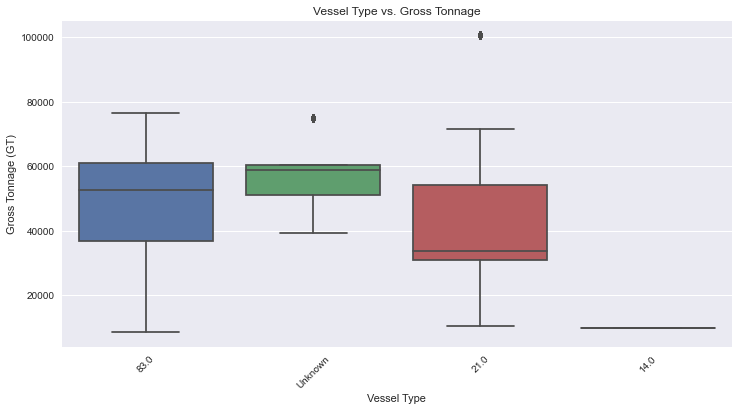

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='vesselType', y='GT', data=train)
plt.title('Vessel Type vs. Gross Tonnage')
plt.xlabel('Vessel Type')
plt.ylabel('Gross Tonnage (GT)')
plt.xticks(rotation=45)
plt.show()